In [10]:
#load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.linear_model import LinearRegression

In [11]:
#This function simply reads the text file with UPS data and extracts xvals and yvals as lists
def read_file(filename, startline):
    #just declaring a list for each column (twiss parameters)
    E_kin, counts = [],[]
    #open tfs file with and read line by line, store each line as a string in a list
    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)
    #from each line, extract a name/number and append it into its relevant column
    for i in range(startline-1,len(copy_lines)-1): #startline-1 in the file is the first relevant one
        line = copy_lines[i]
        E_kin.append(line[0]) #strip element name and type of commas
        counts.append(line[1])
    #extracted values are strings --> cast numbers to floats
    for i in range(0, len(E_kin)):
        E_kin[i] = float(E_kin[i])
        counts[i] = float(counts[i])
    return([E_kin, counts])

# Analysis of the first batch of measurements (Summer 2021):

In [12]:
#call the function on all important textfiles, extract counts at energy bins
[ITO_Radiator_UPS_E_kin, ITO_Radiator_UPS_counts] = read_file("/Users/sebastiankalos/Documents/Moondust/Modena/ITO_Radiator/UPS--17_1-cutoff2.txt", 23)
[ITO_MLI_UPS_E_kin, ITO_MLI_UPS_counts] = read_file("/Users/sebastiankalos/Documents/Moondust/Modena/ITO_MLI/UPS--21_1-Cutoff2.txt", 23)
[SS_Graphit_UPS_E_kin, SS_Graphit_UPS_counts] = read_file("/Users/sebastiankalos/Documents/Moondust/Modena/SS_Graphit33/UPS--6_1-Cutoff2.txt", 23)
[SS_Aerodag_UPS_E_kin, SS_Aerodag_UPS_counts] = read_file("/Users/sebastiankalos/Documents/Moondust/Modena/SS_aerodag_g/Reg8_UPS_cutoff2.txt", 23)
[Ti_XPS_E_kin, Ti_XPS_counts] = read_file("/Users/sebastiankalos/Documents/Moondust/Modena/Ti/XPS--12_Cutoff Low.txt", 23)

Text(0, 0.5, 'counts')

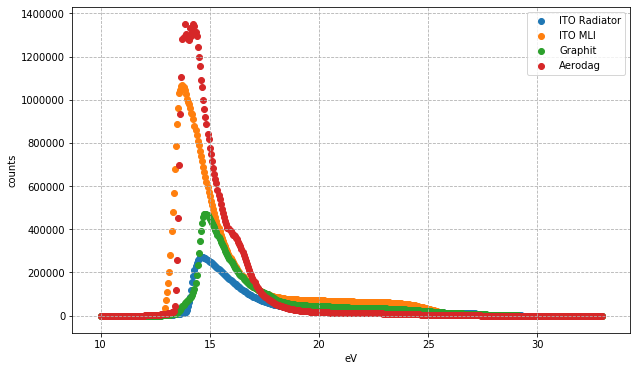

In [13]:
# plot them all materials together for comparison/sanity check
plt.figure(figsize=(10, 6))
plt.scatter(ITO_Radiator_UPS_E_kin, ITO_Radiator_UPS_counts, label="ITO Radiator")
plt.scatter(ITO_MLI_UPS_E_kin, ITO_MLI_UPS_counts, label="ITO MLI")
plt.scatter(SS_Graphit_UPS_E_kin, SS_Graphit_UPS_counts, label="Graphit")
plt.scatter(SS_Aerodag_UPS_E_kin, SS_Aerodag_UPS_counts, label="Aerodag")
plt.legend(loc="upper right")
plt.grid(linestyle='--')
plt.xlabel('eV')
plt.ylabel('counts')

In [14]:
# this function performs the linear regression (after picking a region of the graph),
# computes and returns the Work Function using Fermi level, cutoff and photon energy
# graphs are plotted for each material individually
    
def get_WF(x_vals, y_vals, material, Fermi_level, photon_E, lower_frac, upper_frac):
    # x_vals --> UPS energy readings
    # y_vals --> counts
    # material name ought to be string
    # Fermi level and photon_E in eV
    # upper and lower fraction of the count max select lower an upper boundaries of the linear regression region
    
    m_size = 10 #markersize
    y_max = max(y_vals)
    y_max_ind = y_vals.index(y_max)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_vals, y_vals, label=material, s = m_size) #basic plot
    plt.scatter(x_vals[y_max_ind], y_max, color='red', label = 'max point') #add red max point
    plt.grid(linestyle='--')
    
    #######
    # following picks the region for linear regression:
    count_upper = min(y_vals[:y_max_ind], key=lambda x:abs(x-y_max*upper_frac)) #from max to left, search for count value closest to a fraction of max
    count_upper_ind = y_vals.index(count_upper) #get its index

    count_lower = min(y_vals[:y_max_ind], key=lambda x:abs(x-y_max*lower_frac)) #from max to left, search for count value closest to a fraction of max
    count_lower_ind = y_vals.index(count_lower) #get its index
    #######
    
    # extract intervals for linear regression, (reshape required!) and plot them over
    x = np.array(x_vals[count_lower_ind:count_upper_ind]).reshape((-1, 1))
    y = np.array(y_vals[count_lower_ind:count_upper_ind])

    plt.scatter(x, y, color = 'orange', label='data taken for regression')
    
    # linear regression on the interval here
    model = LinearRegression().fit(x, y)
    x_cutoff = (-1)*model.intercept_/model.coef_ #get x-intercept (cutoff) from slope and y-intercept
    print('cutoff: {:0.2f} eV'.format(x_cutoff[0]))

    plt.scatter(x_cutoff, 0, color = 'green', label='linear fit intercept (cutoff)') #add green cutoff point for sanity
    plt.legend(loc="upper right")
    plt.xlabel('eV')
    plt.ylabel('count')
    
    #next, use fermi level, impinging photon energy and cutoff to get the electronic work function
    DE = Fermi_level - x_cutoff
    WF = photon_E - DE
    WF = round(WF[0], 2)
    print(material, 'WF: ', WF, 'eV')
    return(WF)

cutoff: 13.94 eV
ITO Radiator WF:  3.94 eV


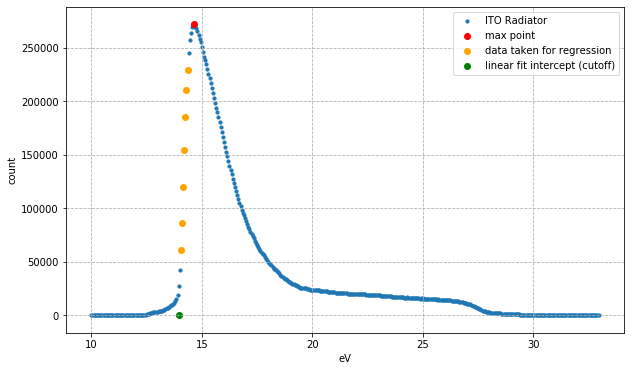

In [15]:
ITO_Radiator_WF = get_WF(ITO_Radiator_UPS_E_kin, ITO_Radiator_UPS_counts, "ITO Radiator", 31.2, 21.2, 1/5, 9/10)

cutoff: 13.05 eV
ITO MLI WF:  3.05 eV


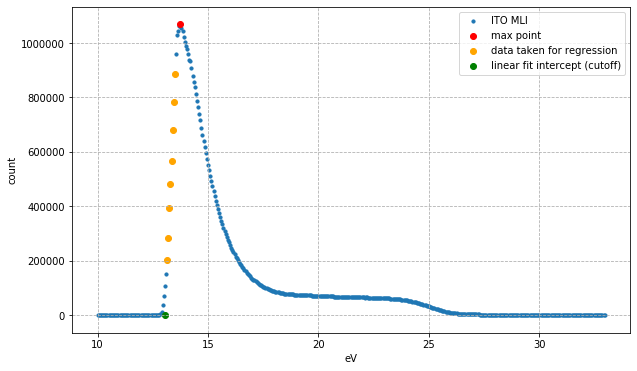

In [16]:
ITO_MLI_WF = get_WF(ITO_MLI_UPS_E_kin, ITO_MLI_UPS_counts, "ITO MLI", 31.2, 21.2, 1/5, 9/10)

cutoff: 14.21 eV
Graphit WF:  4.21 eV


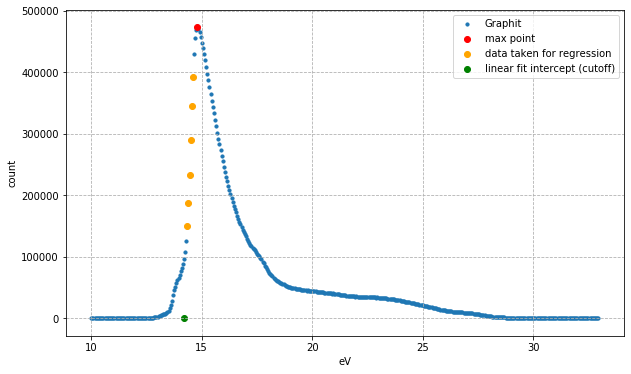

In [17]:
Graphit_WF = get_WF(SS_Graphit_UPS_E_kin, SS_Graphit_UPS_counts, "Graphit", 31.2, 21.2, 3/10, 9/10)

cutoff: 13.45 eV
Aerodag WF:  3.45 eV


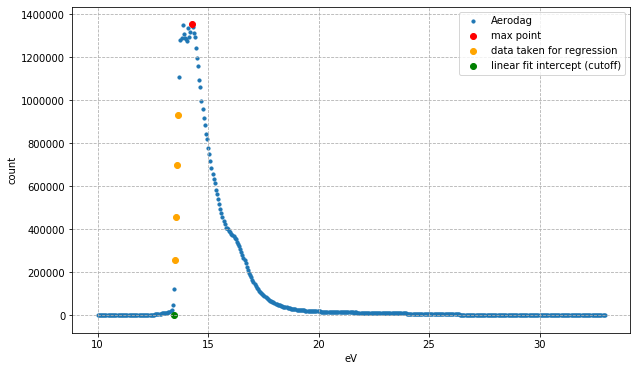

In [18]:
Aerodag_WF = get_WF(SS_Aerodag_UPS_E_kin, SS_Aerodag_UPS_counts, "Aerodag", 31.2, 21.2, 1/5, 8/10)

# Analysis of the second batch of measurements (Fall 2021):

In [19]:
[Ag_UPS_E_kin, Ag_UPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/Ag/UPS--1_Cutoff_Low.txt", 23)
[Au_UPS_E_kin, Au_UPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/Au/UPS--14_Cutoff_Low.txt", 23)
[LHS_XPS_E_kin, LHS_XPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/LuncoSimulant_LHS-1_powder/XPS--15_Cutoff_Low.txt", 23) #charging --> only XPS!
[MLI_1_UPS_E_kin, MLI_1_UPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/MLI_Test_sample_1/UPS--11_Cutoff_Low.txt", 23)
[MLI_2_XPS_E_kin, MLI_2_XPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/MLI_Test_sample_2/XPS--15_Cutoff_Low.txt", 23) #XPS!
[Ti_rod_XPS_E_kin, Ti_rod_XPS_counts] = read_file("AbuDhabi_data/XPS_UPS_data/Ti_rod/XPS--12_Cutoff_Low.txt", 23) #XPS!

# UPS spectra:

Text(0, 0.5, 'counts')

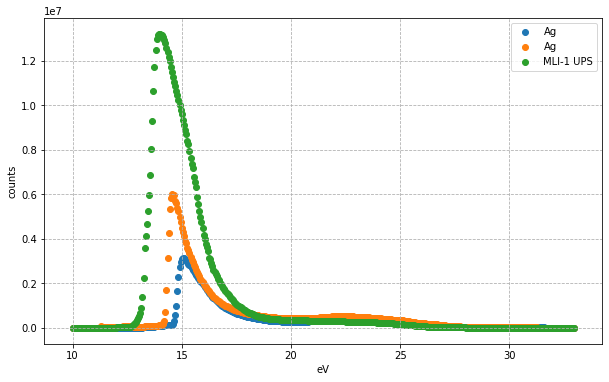

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(Ag_UPS_E_kin, Ag_UPS_counts, label="Ag")
plt.scatter(Au_UPS_E_kin, Au_UPS_counts, label="Ag")
plt.scatter(MLI_1_UPS_E_kin, MLI_1_UPS_counts, label="MLI-1 UPS")
plt.legend(loc="upper right")
plt.grid(linestyle='--')
plt.xlabel('eV')
plt.ylabel('counts')

# XPS spectra:

Text(0, 0.5, 'counts')

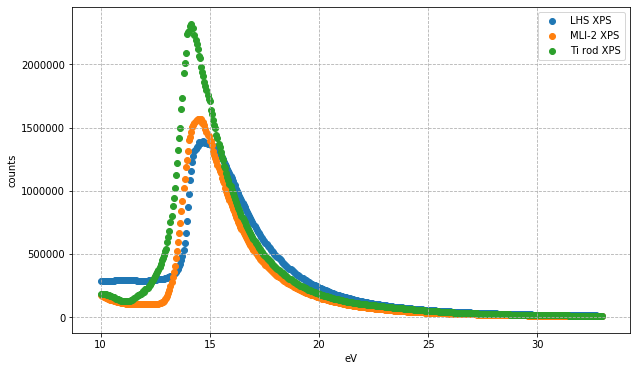

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(LHS_XPS_E_kin, LHS_XPS_counts, label="LHS XPS")
plt.scatter(MLI_2_XPS_E_kin, MLI_2_XPS_counts, label="MLI-2 XPS")
plt.scatter(Ti_rod_XPS_E_kin, Ti_rod_XPS_counts, label="Ti rod XPS")
plt.legend(loc="upper right")
plt.grid(linestyle='--')
plt.xlabel('eV')
plt.ylabel('counts')

# UPS analysis:

cutoff: 14.66 eV
Ag WF:  4.66 eV


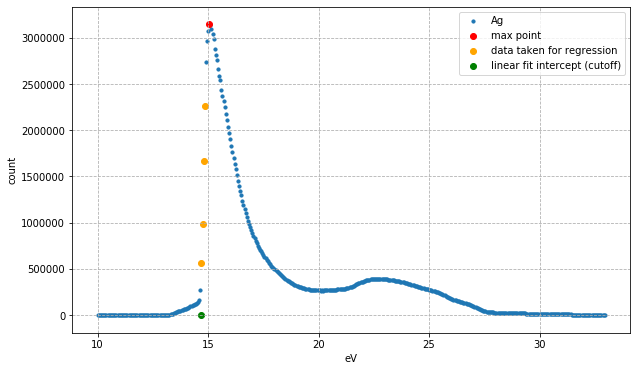

In [22]:
Ag_WF = get_WF(Ag_UPS_E_kin, Ag_UPS_counts, "Ag", 31.2, 21.2, 1/5, 9/10)

cutoff: 14.23 eV
Au WF:  4.23 eV


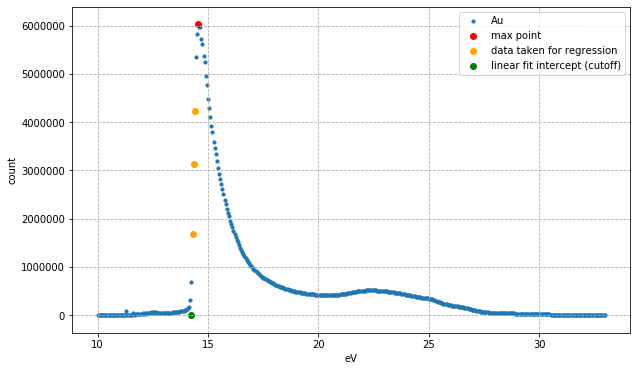

In [23]:
Au_WF = get_WF(Au_UPS_E_kin, Au_UPS_counts, "Au", 31.2, 21.2, 1/5, 9/10)

cutoff: 13.12 eV
MLI test sample 1 WF:  3.12 eV


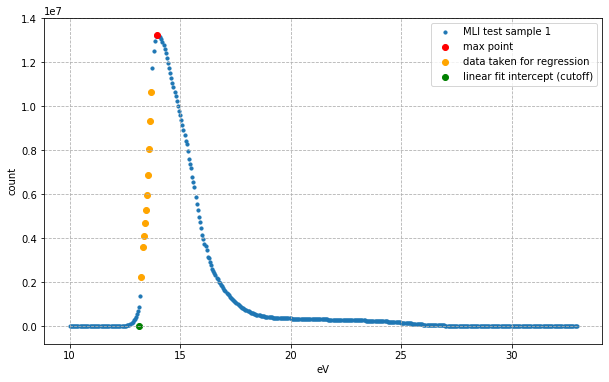

In [24]:
MLI_1_WF = get_WF(MLI_1_UPS_E_kin, MLI_1_UPS_counts, "MLI test sample 1", 31.2, 21.2, 1/5, 9/10)

cutoff: 12.67 eV
Ti WF:  2.67 eV


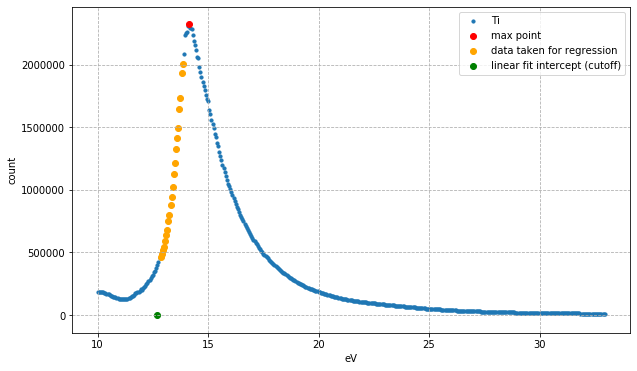

In [27]:
Ti_WF = get_WF(Ti_rod_XPS_E_kin, Ti_rod_XPS_counts, "Ti", 31.2, 21.2, 1/5, 9/10)

In [28]:
# put materials and their work functions into a dataframe:
d = {'Material': ["ITO Radiator", "ITO MLI", "Graphite", "Aerodag","Ag","Au","MLI_1","Ti"], 'Work Function [eV]': [ITO_Radiator_WF, ITO_MLI_WF, Graphit_WF, Aerodag_WF,Ag_WF,Au_WF,MLI_1_WF, Ti_WF]}
df = pd.DataFrame(data=d)
df

,Material,Work Function [eV]
0,ITO Radiator,3.94
1,ITO MLI,3.05
2,Graphite,4.21
3,Aerodag,3.45
4,Ag,4.66
5,Au,4.23
6,MLI_1,3.12
7,Ti,2.67
